## EDA And Sensor Selection

### Work flow

1. Read in sensor and pull associated network
2. Graphical analysis of system
3. Get sensor data and analyse for completeness etc
4. Select sensors for study
5. Output OSM network of road network and associated sensors



In [1]:
# Import modules

import pandas as pd
import osmnx as ox
import numpy as np
import shapely
import geopandas as gpd
from geopandas import GeoDataFrame
from shapely.geometry import Point
import random
import mysql.connector
from matplotlib import pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.dates as mdates
from matplotlib.ticker import MultipleLocator
from statsmodels.tsa.stattools import adfuller

# Function to perform the Augmented Dickey-Fuller test for stationarity
def test_stationarity(timeseries, var):
    # Calculate rolling statistics
    rolmean = timeseries[var].rolling(window=30).mean()
    rolstd = timeseries[var].rolling(window=30).std()

    # Plot rolling statistics
    plt.figure(figsize=(12, 4))
    plt.plot(timeseries[var], label='Original')
    plt.plot(rolmean, label='Rolling Mean')
    plt.plot(rolstd, label='Rolling Std')
    plt.title('Rolling Mean and Standard Deviation')
    plt.legend()
    plt.show()

    # Perform Dickey-Fuller test
    result = adfuller(timeseries[var], autolag='AIC')
    print('Augmented Dickey-Fuller Test:')
    print(f'Test Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    print(f'Critical Values: {result[4]}')
    
    
def analyse_time_series_of_sensor(sensor_id,start_date,end_date):
    
    # Get time series data for sensor
    sql_query = "select * from full_data where site_ID = '{}' and yr = '2022'".format(sensor_id)
    cursor.execute(sql_query)
    result = cursor.fetchall()
    ts = pd.DataFrame(result, columns=[desc[0] for desc in cursor.description])

    # Add date/time index

    i, d = divmod((ts['time_period'] / 4), 1)
    ts['Minute'] = [*map(dec_to_min_dict.get, list(d))]

    years = []
    months = []
    days = []

    for i,r in ts.iterrows():
        years.append(r['data_date'].year)
        months.append(r['data_date'].month)
        days.append(r['data_date'].day)

    ts['Year'] = years
    ts['Month'] = months
    ts['Day'] = days
    ts['Hour'] = ts['data_hour']

    ts['Datetime'] = pd.to_datetime(ts[['Year', 'Month', 'Day', 'Hour', 'Minute']])
    ts.set_index('Datetime', inplace=True)
    ts = ts.sort_index()

    # Create a datetime index with 15-minute frequency
    datetime_index = pd.date_range(start=start_date, end=end_date, freq='15T')
    ts_columns = ['Lane 1', 'Lane 2', 'Lane 3', 'All Lanes']

    # Create all vehicles data frame with 3 lanes
    ts_all = pd.DataFrame(index = datetime_index, columns = ts_columns)

    ts_all['Lane 1'] = ts[ts['Lane'] == 'lane1']['Total_Flow']
    ts_all['Lane 2'] = ts[ts['Lane'] == 'lane2']['Total_Flow']
    ts_all['Lane 3'] = ts[ts['Lane'] == 'lane3']['Total_Flow']
    ts_all['All Lanes'] = ts.groupby(ts.index).sum('Total_Flow')['Total_Flow']

    #Add Weekend Flag
    ts_all['Weekend'] = ts_all.index.dayofweek >= 5
    
    #Data Quality Checks
    # For each column - count zeros, nulls and outliers
    len_ts = len(ts_all)

    for col in ts_columns:
        print('-----------------')
        print('Next Columns : {}'.format(col))
        #Count zeros
        zero_count = (ts_all[col] == 0).sum()
        print('Count of zeros : {}'.format(zero_count))
        print('Rate of zeros : {:.1%}'.format(zero_count / len_ts))

        # Count nulls
        null_count = ts_all[col].isnull().sum()
        print('Count of nulls : {}'.format(null_count))
        print('Rate of nulls : {:.1%}'.format(null_count / len_ts))

        # Identify and count outliers (assuming values more than 2 standard deviations from the mean are outliers)
        mean_value = ts_all[col].mean()
        std_dev = ts_all[col].std()
        outlier_count = ((ts_all[col] > mean_value + 2 * std_dev) | (ts_all[col] < mean_value - 2 * std_dev)).sum()
        print('Count of outliers : {}'.format(outlier_count))
        print('Rate of outliers : {:.1%}'.format(outlier_count / len_ts))
        print('-----------------')
        print()
        print()
        
    plt.plot(ts_all['All Lanes'])
    plt.ylabel('Traffic Count')
    plt.show()
    
    #Interpolate missing data
    for col in ts_columns:
        variable_name = f"{col}_interpolated"
        ts_all[variable_name] = ts_all[col].interpolate(method='time')
        ts_all[variable_name].bfill(inplace=True)
        
        
    fig, ax = plt.subplots(2,1, figsize = [20,6])
    x_position = 0
    xlabels = []
    for i in range(1,53):
        week_data = ts_all[ts_all.index.isocalendar().week == i]
        ax[0].boxplot(week_data[week_data['Weekend'] == False]['All Lanes'].dropna(), positions=[x_position])
        x_position += 1
        xlabels.append(week_data.index[0].strftime('%m-%d'))

    ax[0].set_xticks(np.arange(len(xlabels)))
    ax[0].set_xticklabels(xlabels)
    ax[0].set_title('Weekly Boxplots (Weekday)')
    ax[0].set_xlabel('Date')
    ax[0].set_ylabel('Traffic Count')
    ax[0].xaxis.set_major_locator(MultipleLocator(2))

    x_position = 0
    xlabels = []
    for i in range(1,53):
        week_data = ts_all[ts_all.index.isocalendar().week == i]
        ax[1].boxplot(week_data[week_data['Weekend'] == True]['All Lanes'].dropna(), positions=[x_position])
        x_position += 1
        xlabels.append(week_data.index[0].strftime('%m-%d'))
    ax[1].set_title('Weekly Boxplots (Weekend)')
    ax[1].set_xticks(np.arange(len(xlabels)))
    ax[1].set_xticklabels(xlabels)
    ax[1].set_xlabel('Date')
    ax[1].set_ylabel('Traffic Count')
    ax[1].xaxis.set_major_locator(MultipleLocator(2))

    plt.tight_layout()
    plt.show()
    
    #Typical Day Analysis

    fig, ax = plt.subplots(4,3, figsize = [20,8])

    ax_across = 0
    ax_down = 0

    for m in range(1,13):
        
        x_position = 0
        xlabels = []
        for h in range(24):
            
            month_hour_data = ts_all[(ts_all.index.month == m) & (ts_all.index.hour == h)]
            ax[ax_down,ax_across].boxplot(month_hour_data[month_hour_data['Weekend'] == True]['All Lanes'].dropna(), positions=[x_position])
            x_position += 1
            xlabels.append(month_hour_data.index[0].strftime('%H:%M'))
        ax[ax_down,ax_across].set_xticks(np.arange(len(xlabels)))
        ax[ax_down,ax_across].set_xticklabels(xlabels)
        ax[ax_down,ax_across].xaxis.set_major_locator(MultipleLocator(4))
        
        ax[ax_down,ax_across].set_title(month_hour_data.index[0].strftime('%B'))
        
        if ax_across < 2:
            ax_across += 1
        else:
            ax_across = 0
            ax_down += 1

    plt.suptitle('Typical Weekend Day by Month')
    plt.tight_layout()
    plt.show()


    fig, ax = plt.subplots(4,3, figsize = [20,8])

    ax_across = 0
    ax_down = 0

    for m in range(1,13):
        
        x_position = 0
        xlabels = []
        for h in range(24):
            month_hour_data = ts_all[(ts_all.index.month == m) & (ts_all.index.hour == h)]
            ax[ax_down,ax_across].boxplot(month_hour_data[month_hour_data['Weekend'] == False]['All Lanes'].dropna(), positions=[x_position])
            x_position += 1
            xlabels.append(month_hour_data.index[0].strftime('%H:%M'))
        ax[ax_down,ax_across].set_xticks(np.arange(len(xlabels)))
        ax[ax_down,ax_across].set_xticklabels(xlabels)
        ax[ax_down,ax_across].xaxis.set_major_locator(MultipleLocator(4))
        
        ax[ax_down,ax_across].set_title(month_hour_data.index[0].strftime('%B'))
        
        if ax_across < 2:
            ax_across += 1
        else:
            ax_across = 0
            ax_down += 1

    plt.suptitle('Typical Weekday Day by Month')
    plt.tight_layout()
    plt.show()
    
    
    # Perform seasonal decomposition
    result = seasonal_decompose(ts_all['All Lanes_interpolated'], model='additive', period=365)

    # Plot the original, trend, seasonal, and residual components
    plt.figure(figsize=(12, 8))
    plt.subplot(4, 1, 1)
    plt.plot(ts_all['All Lanes'], label='Original')
    plt.legend()

    plt.subplot(4, 1, 2)
    plt.plot(result.trend, label='Trend')
    plt.legend()

    plt.subplot(4, 1, 3)
    plt.plot(result.seasonal, label='Seasonal')
    plt.legend()

    plt.subplot(4, 1, 4)
    plt.plot(result.resid, label='Residual')
    plt.legend()

    plt.suptitle('Seasonal Decomposition Analysis')
    plt.tight_layout()
    plt.show()
    
    # Call the stationarity analysis function
    test_stationarity(ts_all, 'All Lanes_interpolated')
    
    #Heatmap of flow over time
    
    #Construct heapmap

    num_days = 365
    heatmap = np.zeros((24,num_days))

    m = 1
    d = 1
    array_ind = 0
    for i in range(num_days):
        month_day_data = ts_all[(ts_all.index.month == m) & (ts_all.index.day == d)]
        if len(month_day_data) > 0:
            hourly_aggregated = month_day_data.resample('H').sum()
            heatmap[:,array_ind] = hourly_aggregated['All Lanes_interpolated'].values

            array_ind += 1
            d += 1
        else:
            m += 1
            d = 1
            month_day_data = ts_all[(ts_all.index.month == m) & (ts_all.index.day == d)]
            hourly_aggregated = month_day_data.resample('H').sum()
            heatmap[:,array_ind] = hourly_aggregated['All Lanes_interpolated'].values
            array_ind += 1
    xlabels = pd.date_range(start=start_date, periods=num_days, freq='D')
    ylabels = hourly_aggregated.sort_index( ascending=False).index.strftime('%H:%M')

    # Specify the size of the plot using figsize
    fig, ax = plt.subplots(figsize=(30, 8))

    # Plot the heatmap
    im = ax.imshow(np.flip(heatmap, axis = 0), cmap='viridis', interpolation='nearest')
    plt.colorbar(im, ax=ax)  # Add a colorbar on the side
    ax.set_title('Hourly Flow Heat Map')
    ax.set_xticks(np.arange(len(xlabels)))
    ax.set_xticklabels(xlabels.strftime('%B'))
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1,bymonthday=15))

    ax.set_yticks(np.arange(len(ylabels)))
    ax.set_yticklabels(ylabels)
    ax.yaxis.set_major_locator(MultipleLocator(4))

    plt.show()
    
    #Plot Data Quality Over Time
    
    mean_value_l1 = ts_all['Lane 1'].mean()
    std_dev_l1 = ts_all['Lane 1'].std()

    mean_value_l2 = ts_all['Lane 2'].mean()
    std_dev_l2 = ts_all['Lane 2'].std()

    mean_value_l3 = ts_all['Lane 3'].mean()
    std_dev_l3 = ts_all['Lane 3'].std()

    mean_value_lall = ts_all['All Lanes'].mean()
    std_dev_lall = ts_all['All Lanes'].std()

    num_days = 365
    zero_counts = np.zeros((4,num_days))
    null_counts = np.zeros((4,num_days))
    outlier_counts = np.zeros((4,num_days))

    m = 1
    d = 1
    array_ind = 0

    for i in range(num_days):

        day_data = ts_all[(ts_all.index.month == m) & (ts_all.index.day == d)]
        if len(day_data) > 0:
            zero_counts[0,array_ind] = ((day_data['Lane 1'] == 0).sum() / len(day_data)) * 100
            zero_counts[1,array_ind] = ((day_data['Lane 2'] == 0).sum() / len(day_data)) * 100
            zero_counts[2,array_ind] = ((day_data['Lane 3'] == 0).sum() / len(day_data)) * 100
            zero_counts[3,array_ind] = ((day_data['All Lanes'] == 0).sum() / len(day_data)) * 100

            null_counts[0,array_ind] = (day_data['Lane 1'].isnull().sum() / len(day_data)) * 100
            null_counts[1,array_ind] = (day_data['Lane 2'].isnull().sum() / len(day_data)) * 100
            null_counts[2,array_ind] = (day_data['Lane 3'].isnull().sum() / len(day_data)) * 100
            null_counts[3,array_ind] = (day_data['All Lanes'].isnull().sum() / len(day_data)) * 100

            outlier_counts[0,array_ind] = (((day_data['Lane 1'] > mean_value_l1 + 2 * std_dev_l1) | (day_data['Lane 1'] < mean_value_l1 - 2 * std_dev_l1)).sum()) / len(day_data) * 100
            outlier_counts[1,array_ind] = (((day_data['Lane 2'] > mean_value_l2 + 2 * std_dev_l2) | (day_data['Lane 1'] < mean_value_l2 - 2 * std_dev_l2)).sum()) / len(day_data) * 100
            outlier_counts[2,array_ind] = (((day_data['Lane 3'] > mean_value_l3 + 2 * std_dev_l3) | (day_data['Lane 1'] < mean_value_l3 - 2 * std_dev_l3)).sum()) / len(day_data) * 100
            outlier_counts[3,array_ind] = (((day_data['All Lanes'] > mean_value_lall + 2 * std_dev_lall) | (day_data['All Lanes'] < mean_value_lall - 2 * std_dev_lall)).sum()) / len(day_data) * 100
            array_ind += 1
            d += 1
            
        else:
            m += 1
            d = 1
            day_data = ts_all[(ts_all.index.month == m) & (ts_all.index.day == d)]
            zero_counts[0,array_ind] = ((day_data['Lane 1'] == 0).sum() / len(day_data)) * 100
            zero_counts[1,array_ind] = ((day_data['Lane 2'] == 0).sum() / len(day_data)) * 100
            zero_counts[2,array_ind] = ((day_data['Lane 3'] == 0).sum() / len(day_data)) * 100
            zero_counts[3,array_ind] = ((day_data['All Lanes'] == 0).sum() / len(day_data)) * 100

            null_counts[0,array_ind] = (day_data['Lane 1'].isnull().sum() / len(day_data)) * 100
            null_counts[1,array_ind] = (day_data['Lane 2'].isnull().sum() / len(day_data)) * 100
            null_counts[2,array_ind] = (day_data['Lane 3'].isnull().sum() / len(day_data)) * 100
            null_counts[3,array_ind] = (day_data['All Lanes'].isnull().sum() / len(day_data)) * 100

            outlier_counts[0,array_ind] = (((day_data['Lane 1'] > mean_value_l1 + 2 * std_dev_l1) | (day_data['Lane 1'] < mean_value_l1 - 2 * std_dev_l1)).sum()) / len(day_data) * 100
            outlier_counts[1,array_ind] = (((day_data['Lane 2'] > mean_value_l2 + 2 * std_dev_l2) | (day_data['Lane 1'] < mean_value_l2 - 2 * std_dev_l2)).sum()) / len(day_data) * 100
            outlier_counts[2,array_ind] = (((day_data['Lane 3'] > mean_value_l3 + 2 * std_dev_l3) | (day_data['Lane 1'] < mean_value_l3 - 2 * std_dev_l3)).sum()) / len(day_data) * 100
            outlier_counts[3,array_ind] = (((day_data['All Lanes'] > mean_value_lall + 2 * std_dev_lall) | (day_data['All Lanes'] < mean_value_lall - 2 * std_dev_lall)).sum()) / len(day_data) * 100
            array_ind += 1
            
    xlabels = pd.date_range(start=start_date, periods=num_days, freq='D')    
    fig, ax = plt.subplots(3,1, figsize = [20,6])

    ax[0].plot(zero_counts[0],label = 'Lane 1')
    ax[0].plot(zero_counts[1],label = 'Lane 2')
    ax[0].plot(zero_counts[2],label = 'Lane 3')
    ax[0].plot(zero_counts[3],label = 'All Lanes')
    ax[0].set_xticks(np.arange(len(xlabels)))
    ax[0].set_xticklabels(xlabels.strftime('%b-%d'))
    ax[0].xaxis.set_major_locator(mdates.DayLocator(interval=15))
    ax[0].set_title('Zero Rate')
    ax[0].set_ylabel('Percent')
    ax[0].legend()

    ax[1].plot(null_counts[0],label = 'Lane 1')
    ax[1].plot(null_counts[1],label = 'Lane 2')
    ax[1].plot(null_counts[2],label = 'Lane 3')
    ax[1].plot(null_counts[3],label = 'All Lanes')
    ax[1].set_xticks(np.arange(len(xlabels)))
    ax[1].set_xticklabels(xlabels.strftime('%b-%d'))
    ax[1].xaxis.set_major_locator(mdates.DayLocator(interval=15))
    ax[1].set_title('Missing Rate')
    ax[1].set_ylabel('Percent')
    ax[1].legend()

    ax[2].plot(outlier_counts[0],label = 'Lane 1')
    ax[2].plot(outlier_counts[1],label = 'Lane 2')
    ax[2].plot(outlier_counts[2],label = 'Lane 3')
    ax[2].plot(outlier_counts[3],label = 'All Lanes')
    ax[2].set_xticks(np.arange(len(xlabels)))
    ax[2].set_xticklabels(xlabels.strftime('%b-%d'))
    ax[2].xaxis.set_major_locator(mdates.DayLocator(interval=15))
    ax[2].set_title('Outlier Rate')
    ax[2].set_ylabel('Percent')
    ax[2].legend()

    plt.tight_layout()
    plt.show()
    
    return ts, ts_all

/tmp/ipykernel_917145/456562404.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
# Get sensors
sensors = pd.read_csv('Data/midas_sensor_locations.csv')

#Get network for area just for pimary roads etc
cf = '["highway"~"motorway|motorway_link|primary|trunk"]'
G = ox.graph_from_place('Kent, United Kingdom', network_type='drive', custom_filter=cf, simplify=False)
edge_attributes = ox.graph_to_gdfs(G, nodes=True)[1]

#Get edge centroids
edge_attributes['cent_x'] = edge_attributes['geometry'].centroid.x
edge_attributes['cent_y'] = edge_attributes['geometry'].centroid.y
#Add edge index
edge_attributes['edge_index'] = range(len(edge_attributes))
#Get boundary
graph_boundary=shapely.geometry.box(edge_attributes.geometry.total_bounds[0],edge_attributes.geometry.total_bounds[1],edge_attributes.geometry.total_bounds[2],edge_attributes.geometry.total_bounds[3])

/tmp/ipykernel_917145/3880505661.py:10: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  edge_attributes['cent_x'] = edge_attributes['geometry'].centroid.x
/tmp/ipykernel_917145/3880505661.py:11: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  edge_attributes['cent_y'] = edge_attributes['geometry'].centroid.y


In [3]:
#Output network, sensor and boundary to view in qgis

edge_attributes_gdf = GeoDataFrame(edge_attributes, crs="EPSG:4326", geometry=edge_attributes['geometry'])
edge_attributes_gdf.to_file("Data/examples/kent_road_network.json", driver="GeoJSON")

sensor_points = []
for i,r in sensors.iterrows():
    sensor_points.append(Point([r['Longitude'],r['Latitude']]))
sensors['geometry'] = sensor_points

sensors_in_study = sensors[[graph_boundary.contains(point) for point in sensor_points]]

sensors_gdf = GeoDataFrame(sensors_in_study, crs="EPSG:4326", geometry=sensors_in_study['geometry'])
sensors_gdf.to_file("Data/examples/sensor_locations.json", driver="GeoJSON")

In [4]:
sensor_nearest_edges = ox.distance.nearest_edges(G, list(sensors_in_study['Longitude']), list(sensors_in_study['Latitude']), interpolate=None, return_dist=False)

In [5]:
#Randomly sample sensors to output sensor and nearest edge to check

rand_sens = random.randrange(0,len(sensors_in_study)-1)

sensor_to_check = sensors_gdf.iloc[rand_sens].to_frame().T
edge_to_check = edge_attributes.loc[sensor_nearest_edges[rand_sens]].to_frame().T#

sensor_check_gdf = GeoDataFrame(sensor_to_check, crs="EPSG:4326", geometry=sensor_to_check['geometry'])
sensor_check_gdf['geometry'].to_file("Data/examples/sensor_check.json", driver="GeoJSON")

edge_check_gdf = GeoDataFrame(edge_to_check, crs="EPSG:4326", geometry=edge_to_check['geometry'])
edge_check_gdf['geometry'].to_file("Data/examples/edge_check.json", driver="GeoJSON")

## Time Series Exploratory Data Analysis

- Completeness
- Methods for missing data imputation
- Analyse stationarity of data
- Analyse any seasonanality


### Specific To Do:

- For a random sensor:
    - Data quality checks - how are nulls represented? Any processing steps to handle this? How to measure null / missing / outliers
    - What about lanes / vehicle types?
        - Treat separately? Aggregate? Ignore (for now)? Anything else?
    - More detailed time series checks e.g., stationarity etc with analysis & interpretation

In [6]:
dec_to_min_dict = {
    0.0 : 0,
    0.25 : 15,
    0.50 : 30,
    0.75 : 45
    }

In [7]:
host = "localhost"
user = "chris"
password = "password"
database = "midas"

# Establish a database connection
connection = mysql.connector.connect(
    host=host,
    user=user,
    password=password,
    database=database
)

cursor = connection.cursor(buffered=True)

In [8]:
roads = []

for i in list(sensors_in_study['site_ID']):
    roads.append(i.split('/')[0])

sensors_in_study['Road'] = roads

/tmp/ipykernel_917145/4097086511.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sensors_in_study['Road'] = roads


In [9]:
rand_sens = random.randrange(0,len(sensors_in_study)-1)
next_sensor = sensors_gdf.iloc[rand_sens].to_frame().T

      site_ID Latitude Longitude count(*)                  geometry
45  M20/6514A  51.3044  0.444096   278402  POINT (0.444096 51.3044)


-----------------
Next Columns : Lane 1
Count of zeros : 366
Rate of zeros : 1.0%
Count of nulls : 13855
Rate of nulls : 39.5%
Count of outliers : 713
Rate of outliers : 2.0%
-----------------


-----------------
Next Columns : Lane 2
Count of zeros : 305
Rate of zeros : 0.9%
Count of nulls : 13680
Rate of nulls : 39.0%
Count of outliers : 51
Rate of outliers : 0.1%
-----------------


-----------------
Next Columns : Lane 3
Count of zeros : 304
Rate of zeros : 0.9%
Count of nulls : 13696
Rate of nulls : 39.1%
Count of outliers : 49
Rate of outliers : 0.1%
-----------------


-----------------
Next Columns : All Lanes
Count of zeros : 548
Rate of zeros : 1.6%
Count of nulls : 1175
Rate of nulls : 3.4%
Count of outliers : 1477
Rate of outliers : 4.2%
-----------------




/tmp/ipykernel_917145/3210780982.py:33: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  datetime_index = pd.date_range(start=start_date, end=end_date, freq='15T')


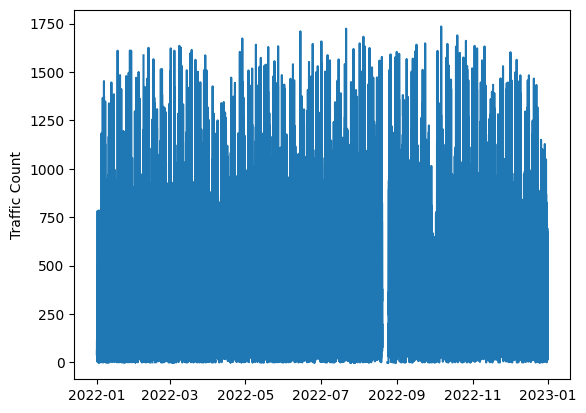

/tmp/ipykernel_917145/3210780982.py:82: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  ts_all[variable_name].bfill(inplace=True)
/tmp/ipykernel_917145/3210780982.py:82: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try u

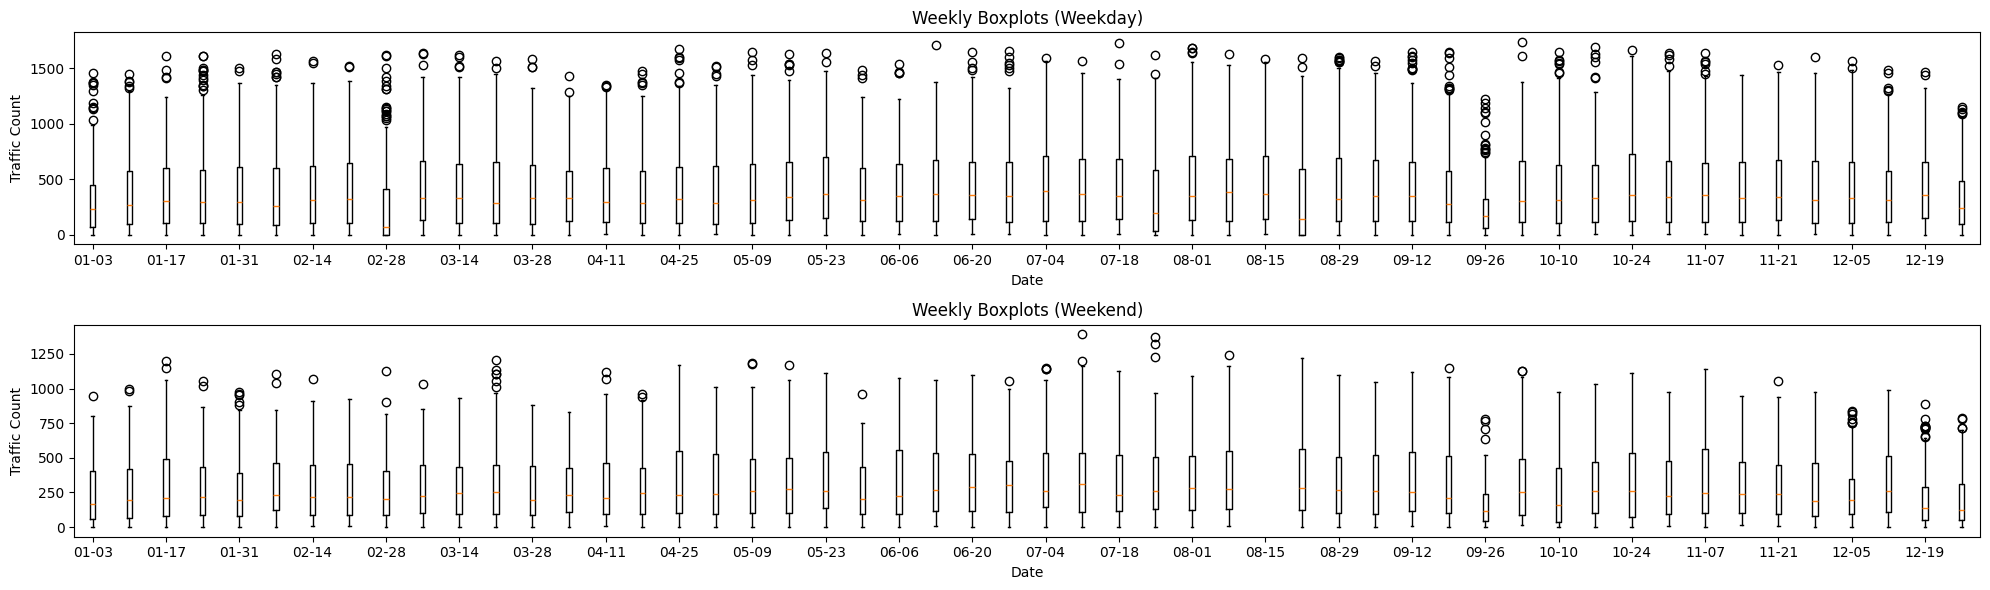

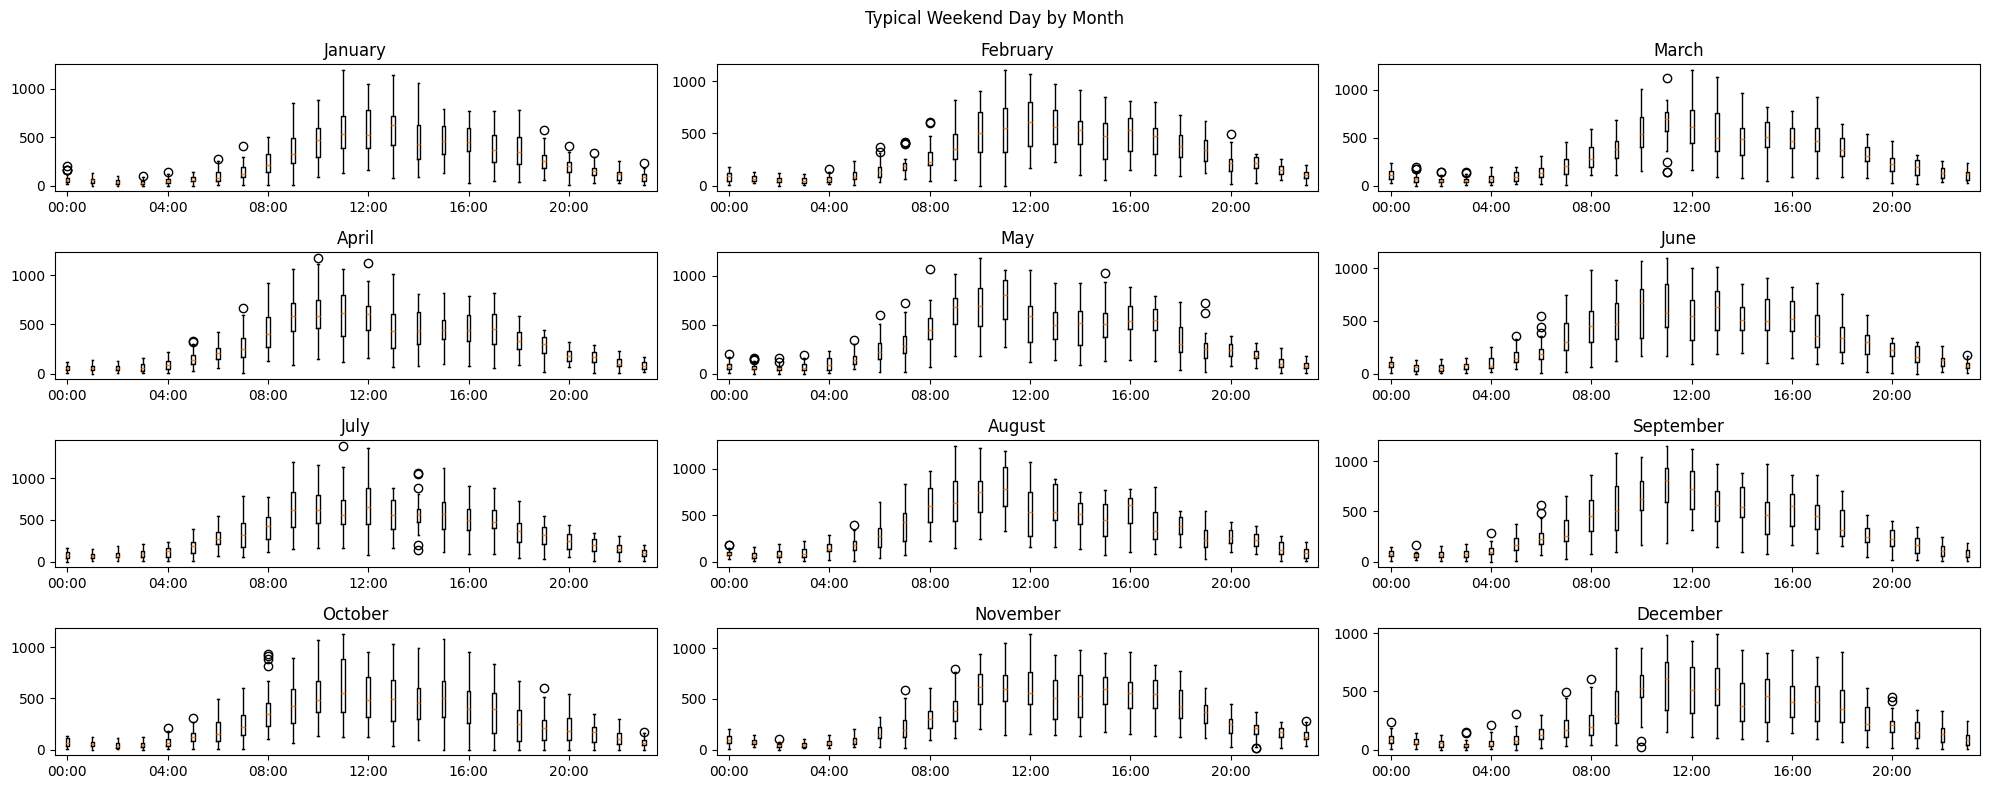

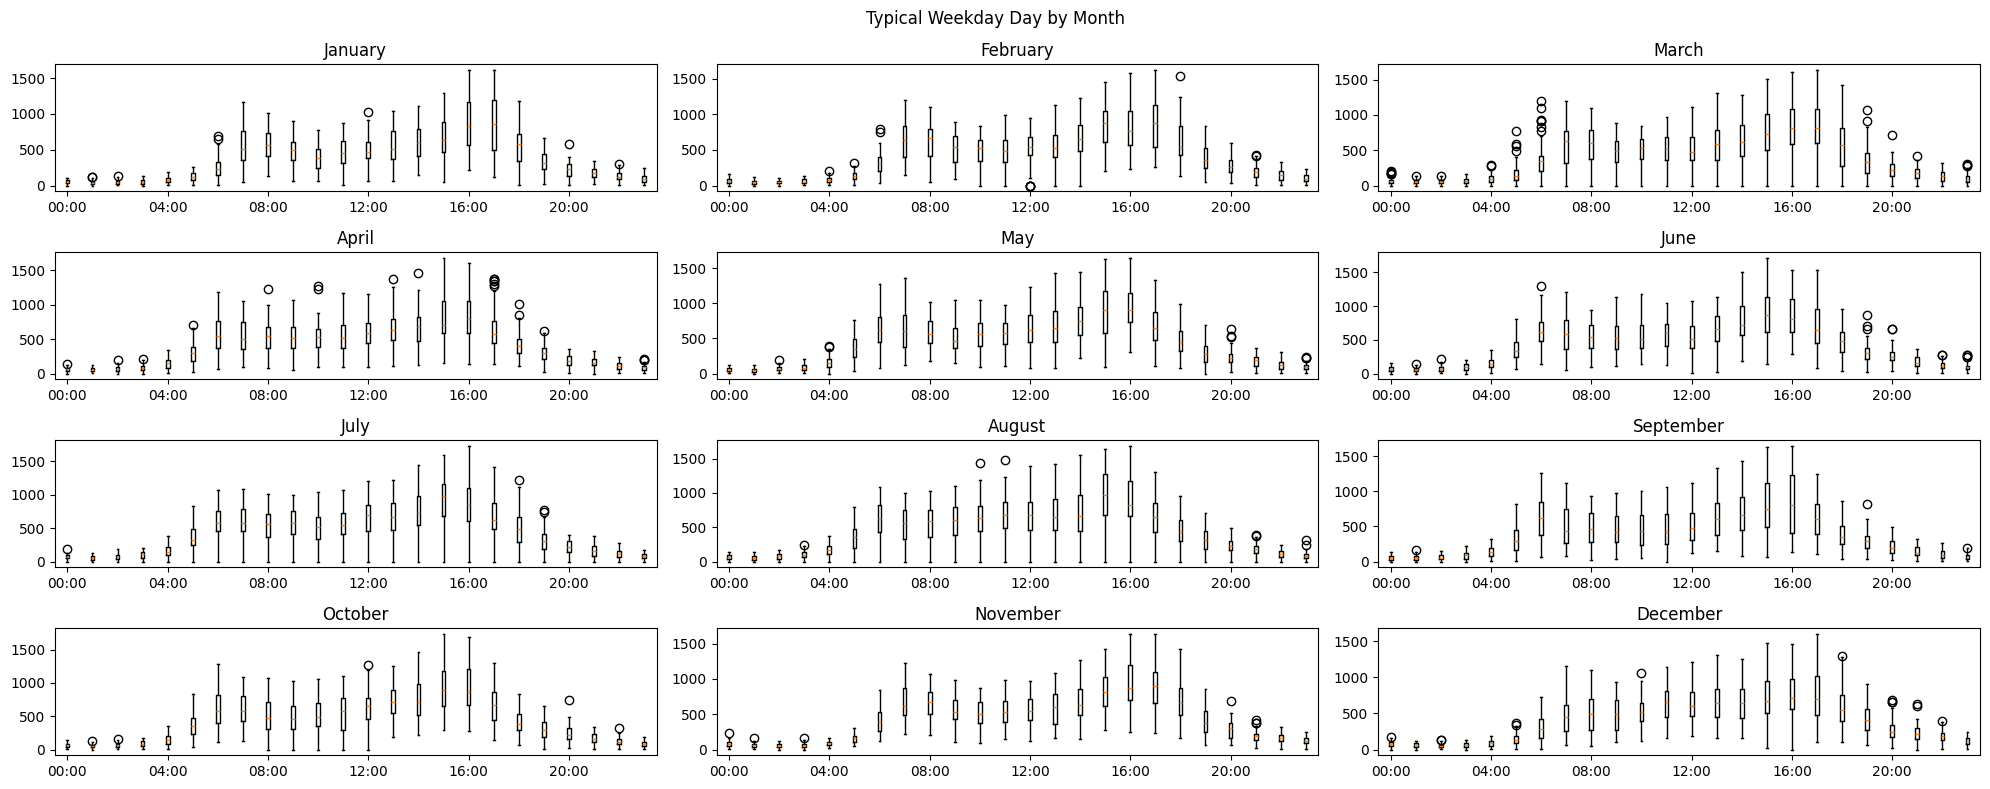

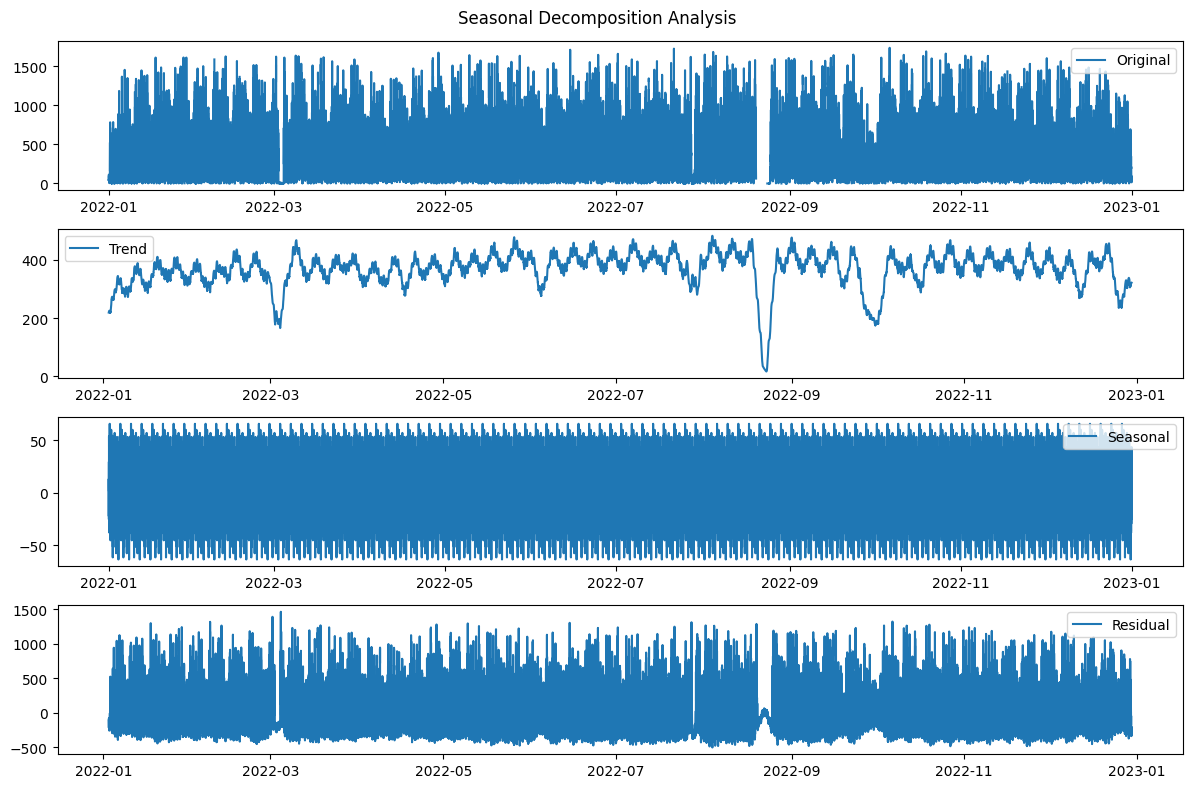

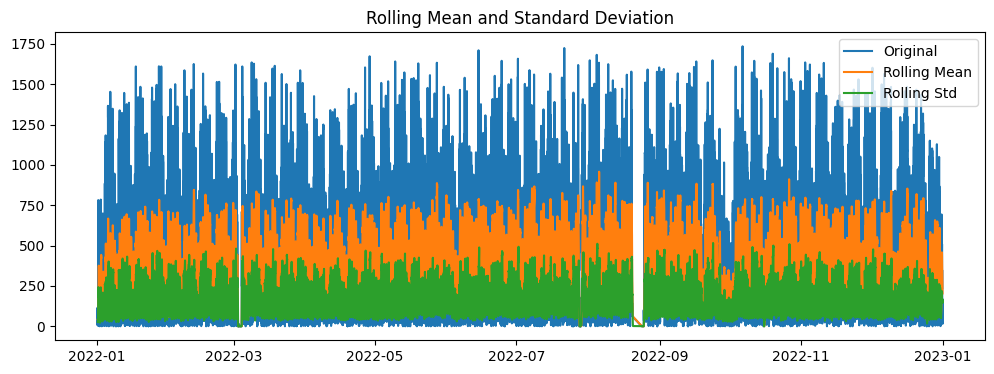

Augmented Dickey-Fuller Test:
Test Statistic: -35.54211677479054
p-value: 0.0
Critical Values: {'1%': -3.430536920280192, '5%': -2.861622614143799, '10%': -2.5668139729124237}


/tmp/ipykernel_917145/3210780982.py:224: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hourly_aggregated = month_day_data.resample('H').sum()
/tmp/ipykernel_917145/3210780982.py:233: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hourly_aggregated = month_day_data.resample('H').sum()


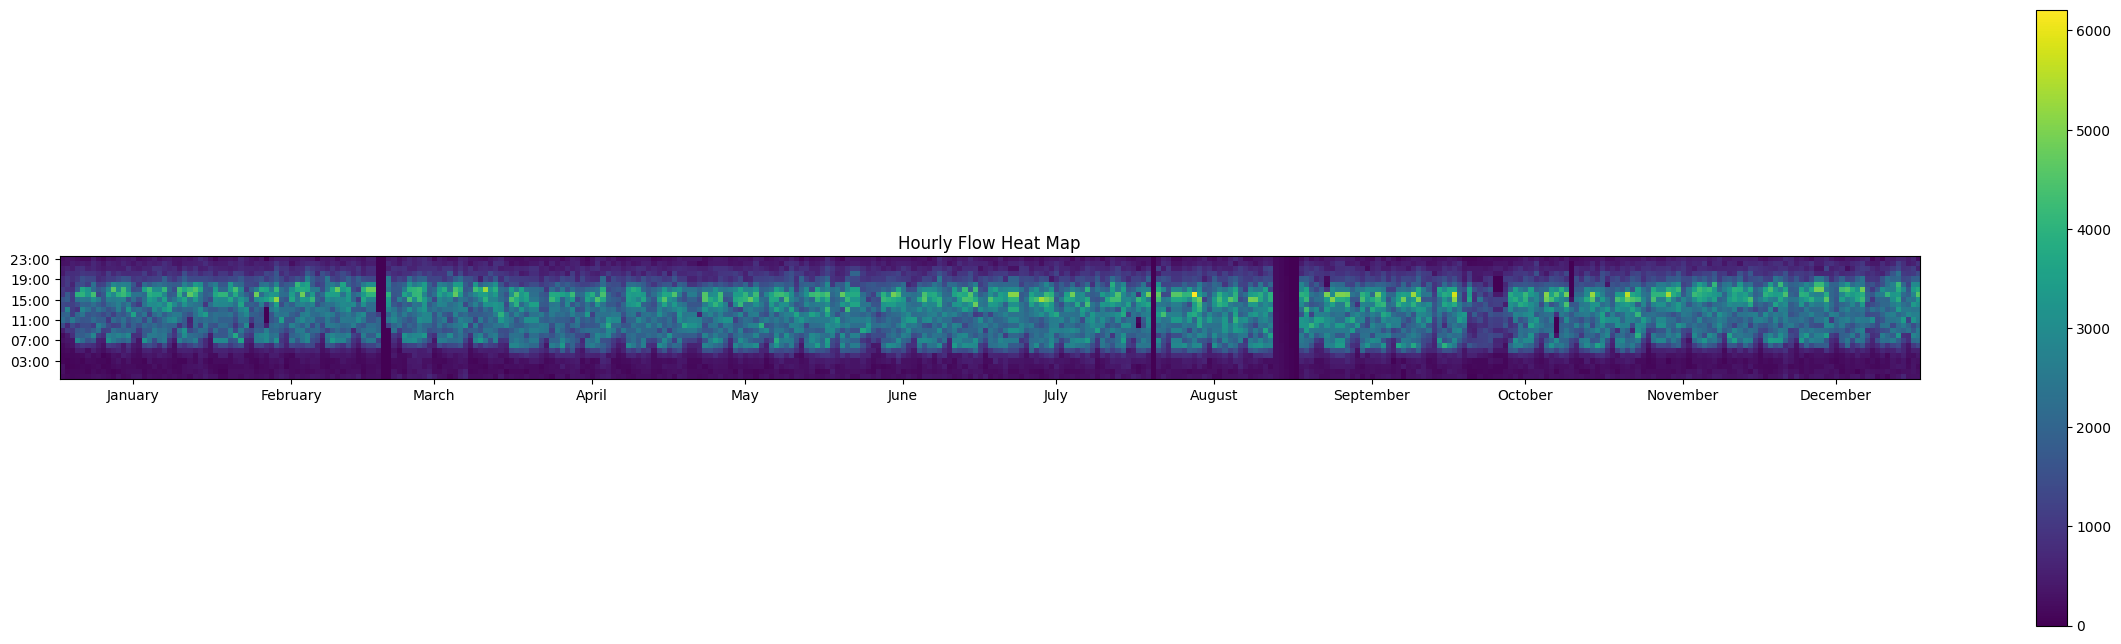

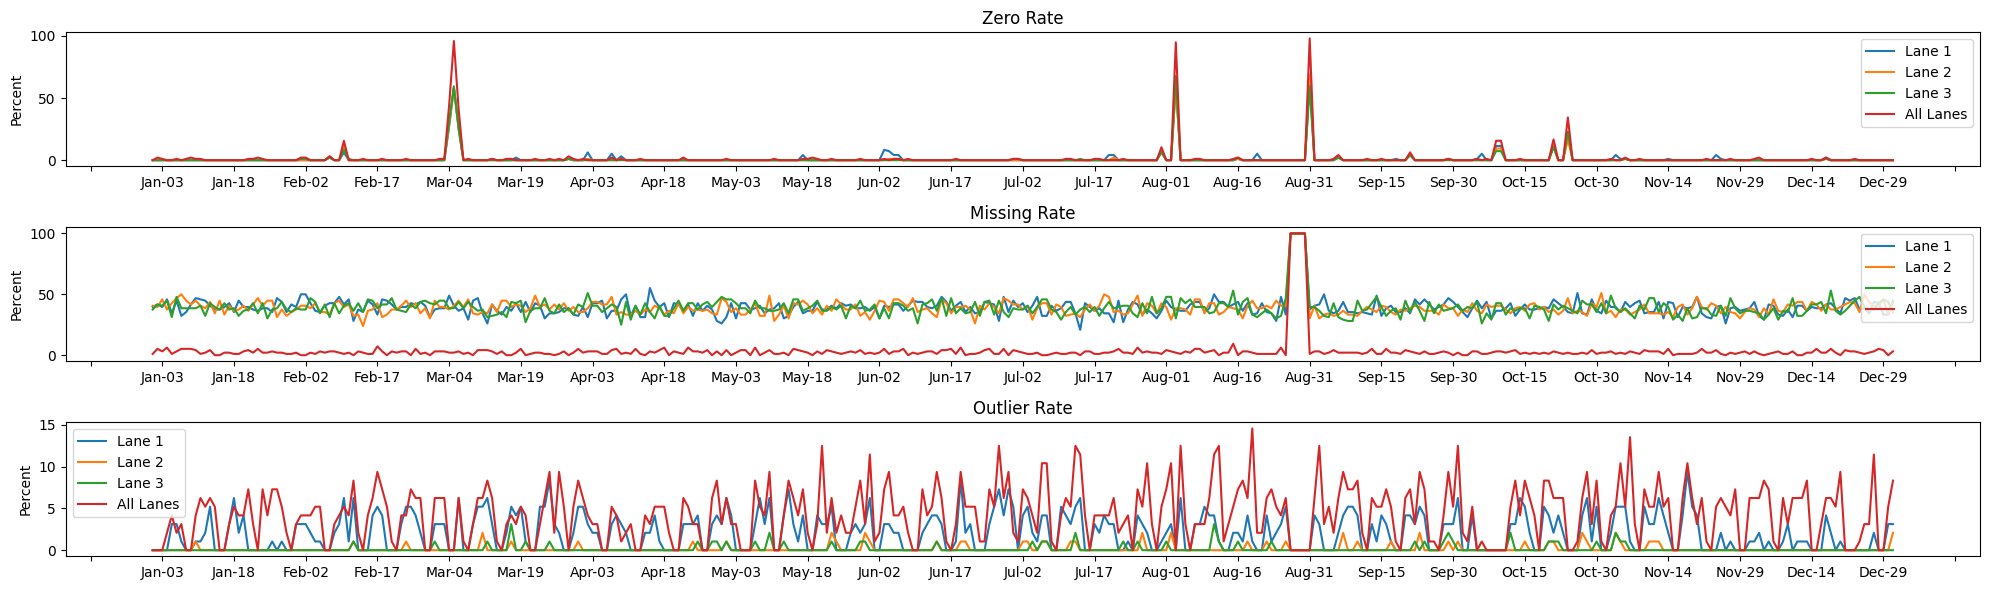

In [12]:

start_date = '2022-01-01'
end_date = '2022-12-31 23:45:00'  # End of December 2022

rand_sens = random.randrange(0,len(sensors_in_study)-1)
next_sensor = sensors_gdf.iloc[rand_sens].to_frame().T
sensor_id = next_sensor['site_ID'].values[0]
ts_1, ts_all_1 = analyse_time_series_of_sensor(sensor_id,start_date,end_date)

-----------------
Next Columns : Lane 1
Count of zeros : 7325
Rate of zeros : 20.9%
Count of nulls : 13954
Rate of nulls : 39.8%
Count of outliers : 125
Rate of outliers : 0.4%
-----------------


-----------------
Next Columns : Lane 2
Count of zeros : 1705
Rate of zeros : 4.9%
Count of nulls : 13884
Rate of nulls : 39.6%
Count of outliers : 288
Rate of outliers : 0.8%
-----------------


-----------------
Next Columns : Lane 3
Count of zeros : 0
Rate of zeros : 0.0%
Count of nulls : 35040
Rate of nulls : 100.0%
Count of outliers : 0
Rate of outliers : 0.0%
-----------------


-----------------
Next Columns : All Lanes
Count of zeros : 4528
Rate of zeros : 12.9%
Count of nulls : 5671
Rate of nulls : 16.2%
Count of outliers : 1505
Rate of outliers : 4.3%
-----------------




/tmp/ipykernel_917145/3210780982.py:33: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  datetime_index = pd.date_range(start=start_date, end=end_date, freq='15T')


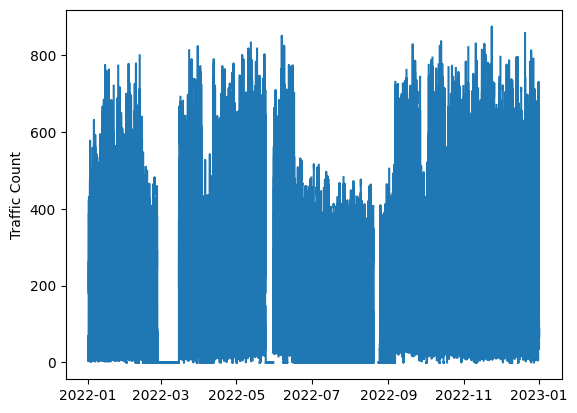

/tmp/ipykernel_917145/3210780982.py:82: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  ts_all[variable_name].bfill(inplace=True)
/tmp/ipykernel_917145/3210780982.py:82: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try u

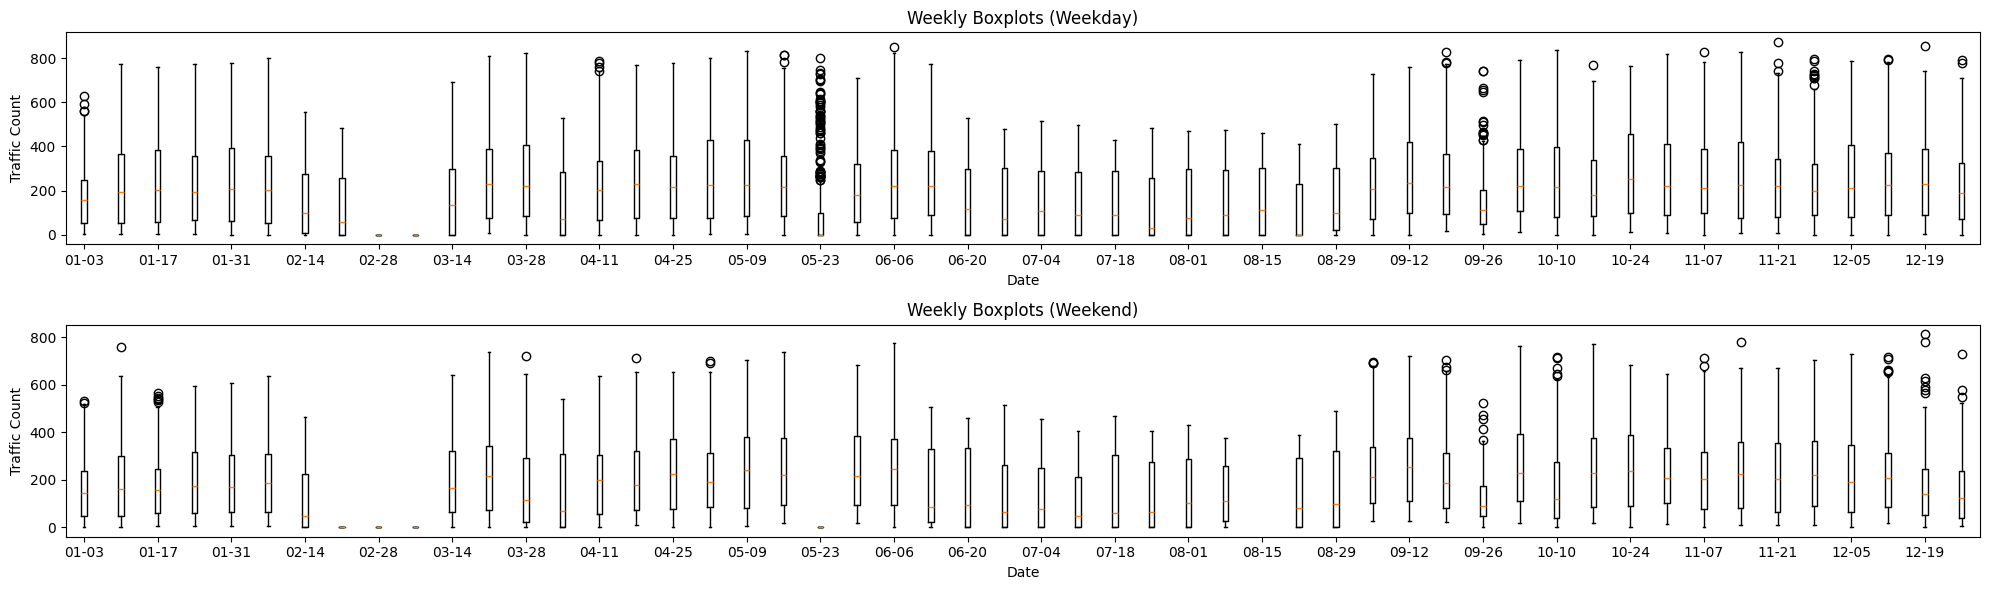

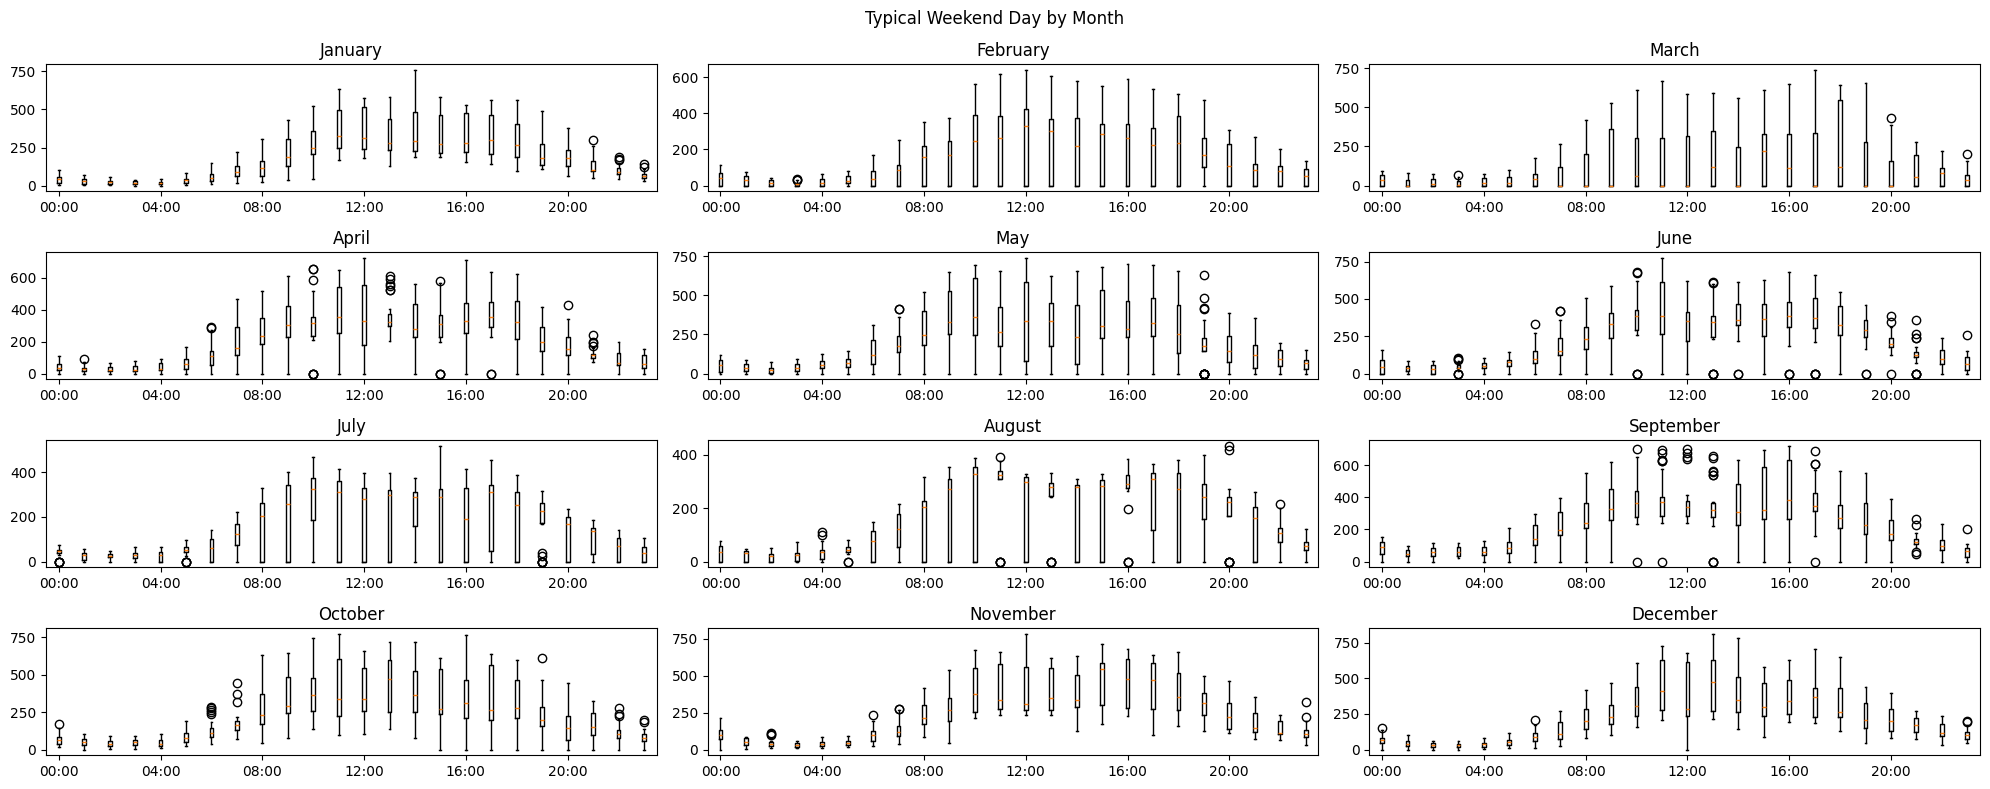

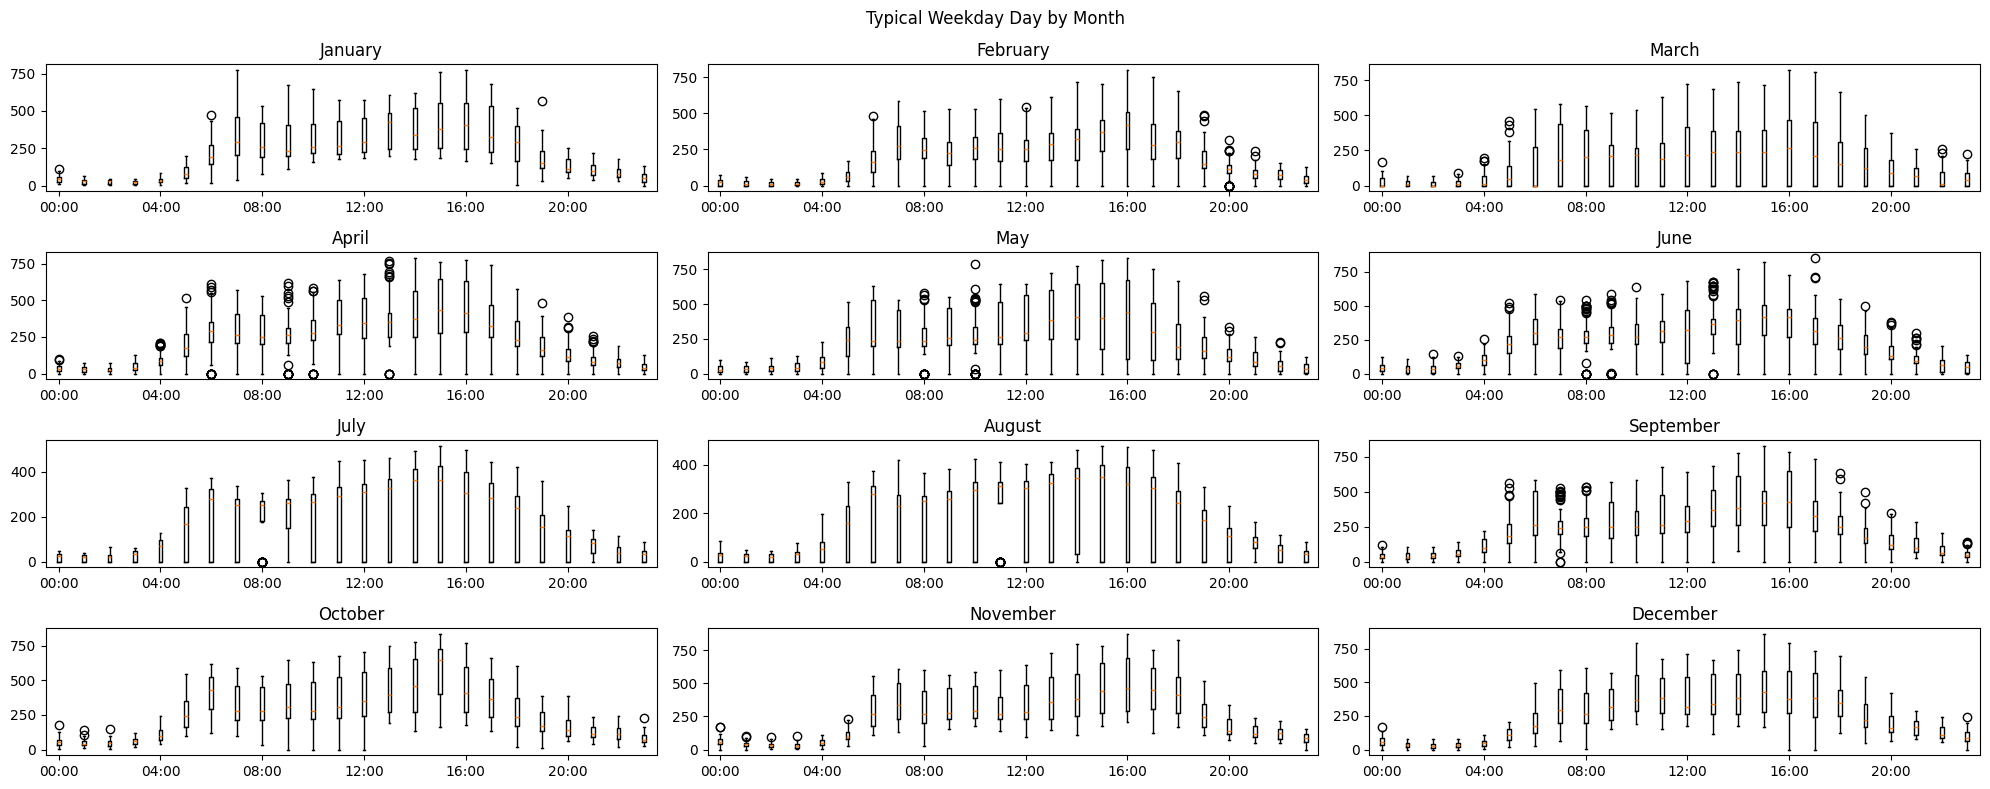

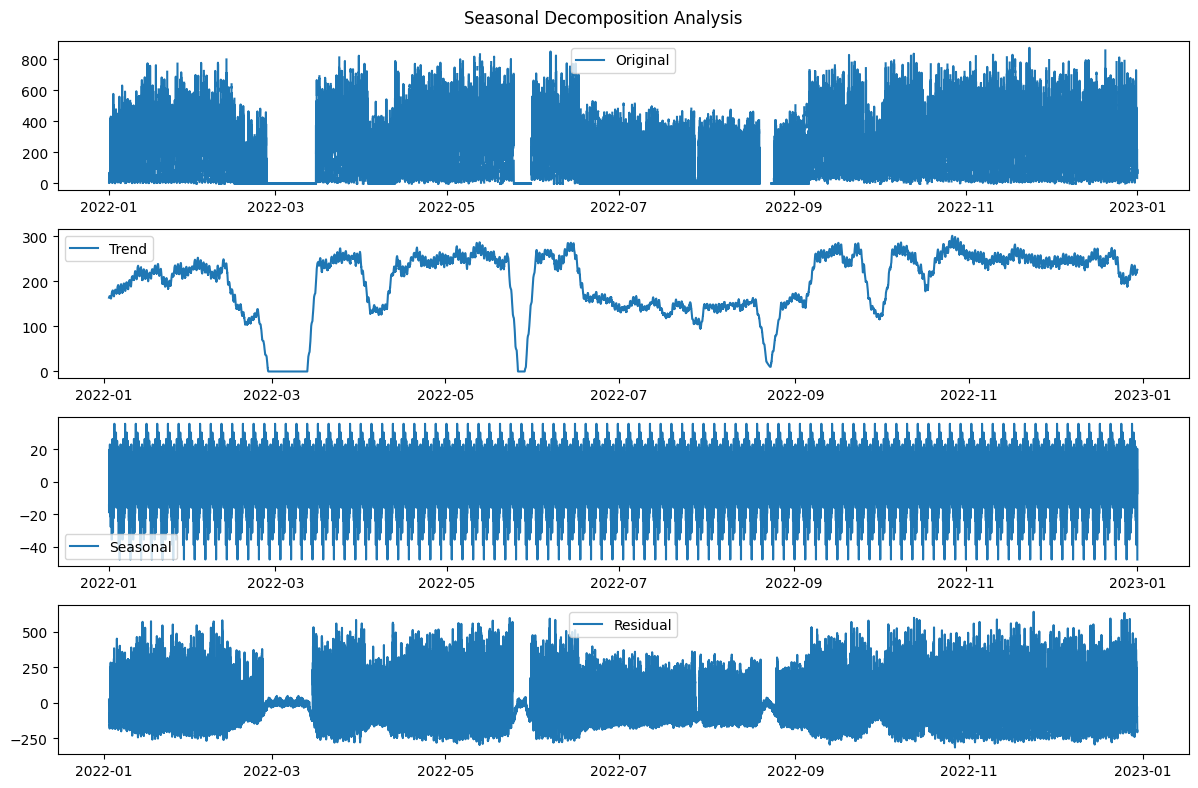

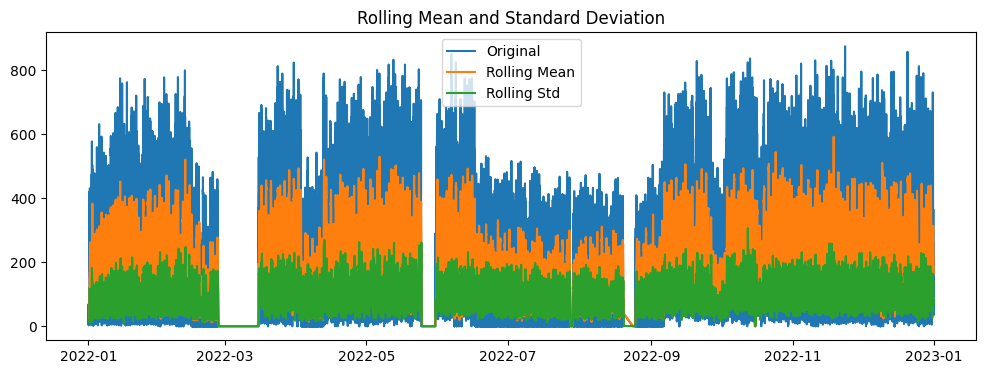

Augmented Dickey-Fuller Test:
Test Statistic: -25.11963474812431
p-value: 0.0
Critical Values: {'1%': -3.430536920280192, '5%': -2.861622614143799, '10%': -2.5668139729124237}


/tmp/ipykernel_917145/3210780982.py:224: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hourly_aggregated = month_day_data.resample('H').sum()
/tmp/ipykernel_917145/3210780982.py:233: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hourly_aggregated = month_day_data.resample('H').sum()


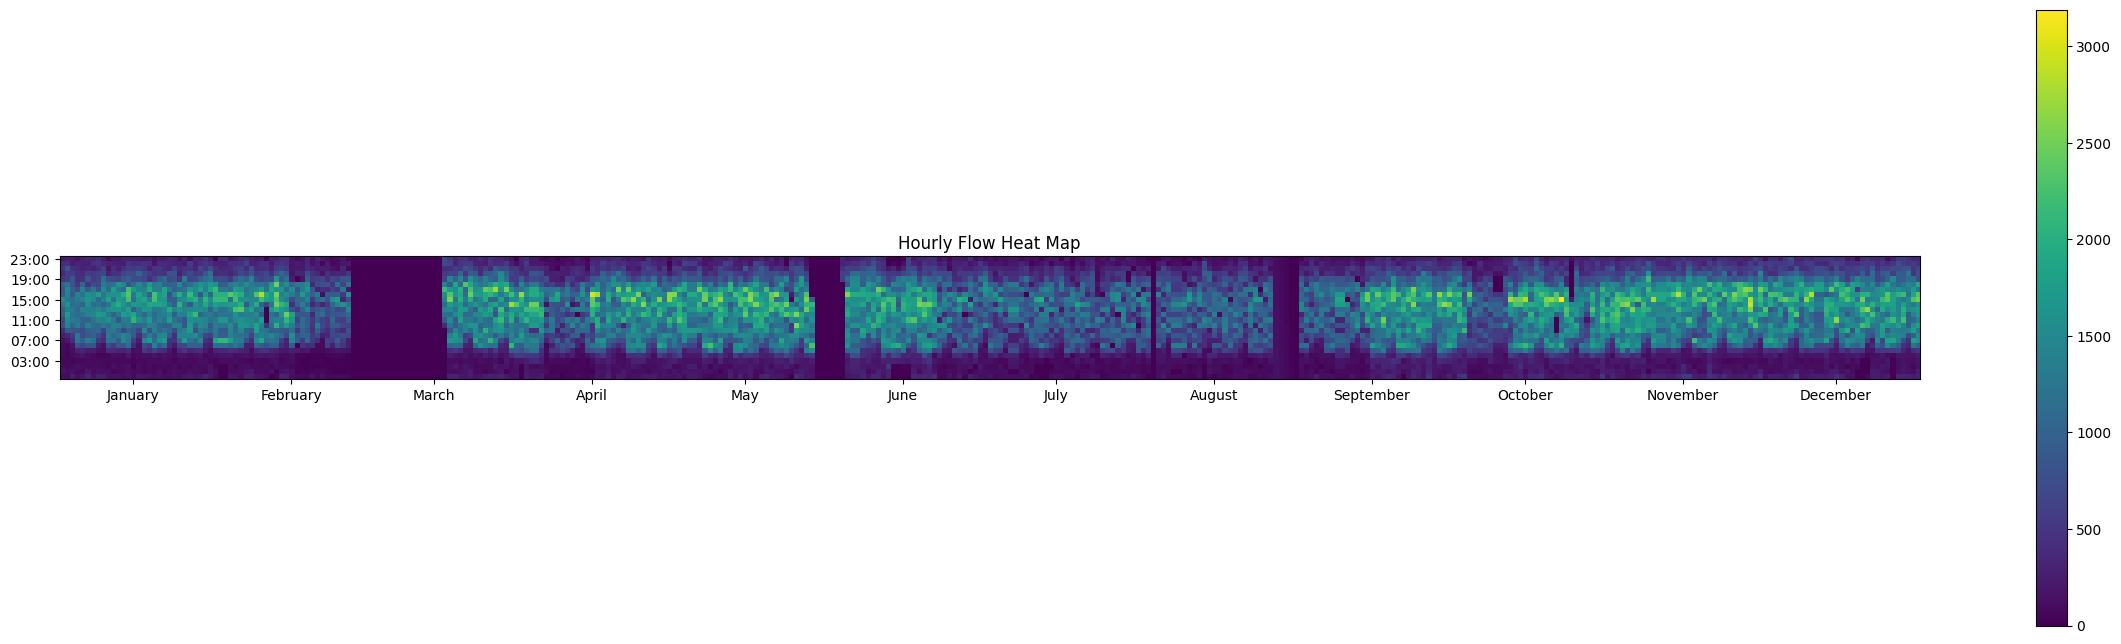

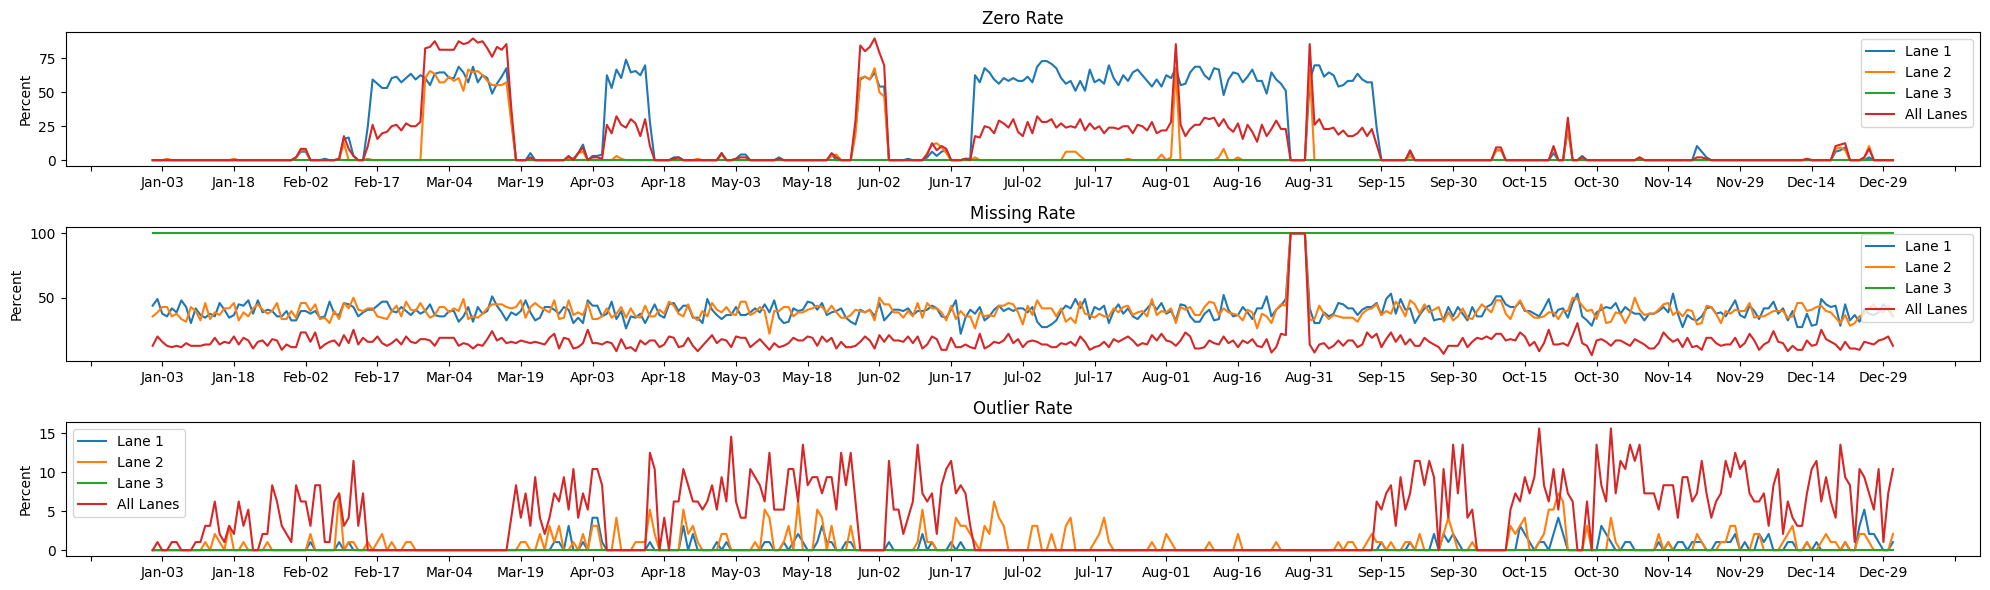

In [13]:
rand_sens = random.randrange(0,len(sensors_in_study)-1)
next_sensor = sensors_gdf.iloc[rand_sens].to_frame().T
sensor_id = next_sensor['site_ID'].values[0]
ts_2, ts_all_2 = analyse_time_series_of_sensor(sensor_id,start_date,end_date)

### Time Series Analysis

- Missing data
- Summary stats over time. Show summarised boxplots over time.
- Seasonal decomposition
- Auto correlation / partial auto correlation analysis
- Stationarity analysis
- Time-series decomposition
- Heapmaps of data

## GeoSpatial Analysis

### To Consider (ChatGPT):

- Spatial Correlation Analysis (Calculate spatial correlation coefficients, such as Pearson correlation or spatial autocorrelation, between pairs of sensors)
- Geospatial Visualization (Create geospatial visualizations, such as heatmaps or spatial scatter plots, to visually explore patterns and relationships between sensor locations)
- Distance-Based Analysis (Explore the relationship between sensor readings and the physical distance between sensors. Techniques such as variograms or semivariograms can be used to analyze how the spatial correlation changes with distance.)
- Spatial Regression Models (Use spatial regression models to account for spatial dependencies explicitly. Spatial autoregressive models or spatial lag models incorporate spatial relationships into regression analyses, considering the influence of neighboring sensors)
- Cluster Analysis (Apply clustering techniques to group sensors with similar behavior or characteristics. Hierarchical clustering or k-means clustering can help identify spatially cohesive groups of sensors.)
- Network Analysis (Treat the sensors as nodes in a network and analyze the connectivity and flow of information or traffic between them. Network metrics, such as centrality measures, can identify key sensors in the network.)
- Spatial Decomposition (Apply spatial decomposition methods to decompose the spatial variability of sensor data. Principal Component Analysis (PCA) can be extended to consider spatial relationships when analyzing sensor data.)
- Spatial Clustering of Sensors (Use spatial clustering algorithms to group sensors based on their geographical proximity and similarities in observed patterns. This can help identify regions with coherent sensor behavior)
- Geostatistics (Utilize geostatistical methods, such as kriging, to model and predict sensor values while considering the spatial structure and dependencies in the data)
- "Fan out from Dover" - time to reach sensor along with sensor quality


### Notes
Spatial auto correlation (e.g, using moran's I) is challenging with time-series. See this paper for proposed method if it's going to be useful. https://www.tandfonline.com/doi/full/10.1080/10095020.2019.1643609

In [15]:
compare_sensors = pd.DataFrame(index = ts_all_2.index)

compare_sensors['ts1'] = ts_all_1['All Lanes_interpolated']
compare_sensors['ts2'] = ts_all_2['All Lanes_interpolated']

# Compute cross-correlation
cross_corr_matrix = compare_sensors.corr()

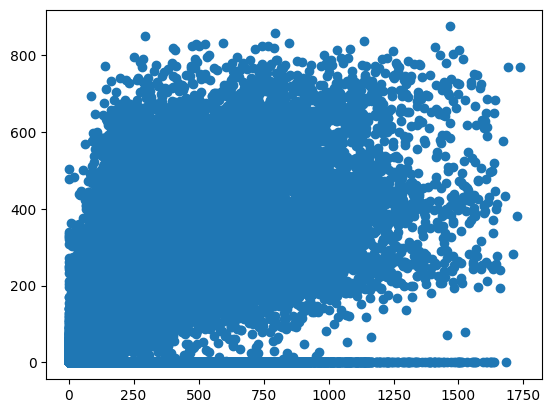

In [20]:
#Scatter Plots

plt.scatter(ts_all_1['All Lanes_interpolated'],ts_all_2['All Lanes_interpolated'])

plt.show()